# Intro

Welcome to this computer vision challenge!
You have a lot of images of fruits and vegetables in front of you, they all look like what you'd expect to get from a Search Engine. The images are all gathered in that link: https://drive.google.com/drive/folders/1q3_pwOmD-HTOJecFv3Ebz1cZWl0PfYfU?usp=sharing

You have everything you need to open the safe now!...

Wait, to help you get things started a bit, we'll give you an other link to a Kaggle dataset that gathers images of a *similar distribution* with labels provided!! You are welcome. We'll write the starter code to download both the Kaggle/training set and the mystery/test set you need to use to crack the safe, good luck!

In [1]:
# Don't forget to activate a GPU runtime on Google Colab if you want to train DL models!

# Load Training set

In [2]:
# Connect to Gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# To connect to kaggle and download the dataset, download your kaggle.json from Kaggle to connectto the python API
!pip install --upgrade --force-reinstall --no-deps kaggle
#!mkdir ~/.kaggle
!rm -rf ~/.kaggle      # when I created the folder, it says the file or dir already exits
!mkdir ~/.kaggle

 # put kaggle json file in content folder

!cp "/content/kaggle.json" ~/.kaggle # <- change this line to set the right path to your kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

  Using cached kaggle-1.5.16-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [4]:
# Download the train data
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition -p files/
!unzip files/fruit-and-vegetable-image-recognition.zip -d fruits-train/

100% 1.98G/1.98G [00:19<00:00, 121MB/s]
100% 1.98G/1.98G [00:19<00:00, 109MB/s]
Archive:  files/fruit-and-vegetable-image-recognition.zip
  inflating: fruits-train/test/apple/Image_1.jpg  
  inflating: fruits-train/test/apple/Image_10.jpg  
  inflating: fruits-train/test/apple/Image_2.jpg  
  inflating: fruits-train/test/apple/Image_3.jpg  
  inflating: fruits-train/test/apple/Image_4.jpg  
  inflating: fruits-train/test/apple/Image_5.jpg  
  inflating: fruits-train/test/apple/Image_6.JPG  
  inflating: fruits-train/test/apple/Image_7.jpg  
  inflating: fruits-train/test/apple/Image_8.jpg  
  inflating: fruits-train/test/apple/Image_9.jpg  
  inflating: fruits-train/test/banana/Image_1.jpg  
  inflating: fruits-train/test/banana/Image_10.jpg  
  inflating: fruits-train/test/banana/Image_2.jpg  
  inflating: fruits-train/test/banana/Image_3.jpg  
  inflating: fruits-train/test/banana/Image_4.jpg  
  inflating: fruits-train/test/banana/Image_5.jpg  
  inflating: fruits-train/test/banana/

# Create Datasets

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

train_data = 'fruits-train/train'
val_data = 'fruits-train/validation'
test_data = 'fruits-train/test'

In [6]:
# make training and validation classification sets
training_set = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

validation_set = tf.keras.utils.image_dataset_from_directory(
     val_data,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


In [7]:
class_names = training_set.class_names
print(class_names)

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


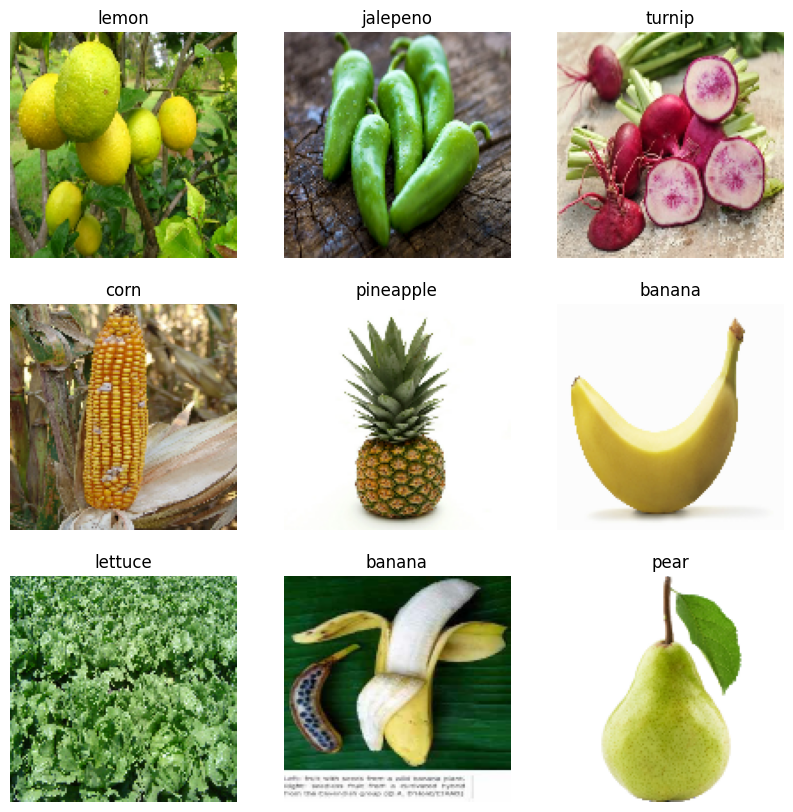

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    x = np.where(labels[i] == 1)
    x = int(x[0])
    plt.title(class_names[x])
    plt.axis("off")

# Create Model

In [9]:
# rescale pixel values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# make base model with MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [10]:
# print example batch
image_batch, label_batch = next(iter(training_set))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 1280)


In [11]:
# freeze convolutional base of MobileNet V2
base_model.trainable = False

# add classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(36)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

# create model with functional API
inputs = tf.keras.Input(shape=(128, 128, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = prediction_layer(x)
outputs = tf.keras.activations.softmax(x, axis=-1)
model = tf.keras.Model(inputs, outputs)

(32, 1280)
(32, 36)


In [12]:
# print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 128, 128, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 128, 128, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

# Compile and Train Model

In [13]:
# compile model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[
      'accuracy',
       tf.keras.metrics.AUC(from_logits=False, multi_label=True),
       tf.keras.metrics.Precision(class_id=0),
       tf.keras.metrics.Recall(class_id=0),
    ],)

In [14]:
# train model
initial_epochs = 20

loss = model.evaluate(validation_set)
print(loss)

11/11 [==============================] - 13s 162ms/step - loss: 3.9808 - accuracy: 0.0199 - auc: 0.5563 - precision: 0.0000e+00 - recall: 0.0000e+00
[3.980825185775757, 0.01994301937520504, 0.5563470721244812, 0.0, 0.0]


In [15]:
history = model.fit(training_set,
                    epochs=initial_epochs,
                    validation_data=validation_set)

Epoch 1/20
98/98 [==============================] - 74s 669ms/step - loss: 3.7274 - accuracy: 0.0729 - auc: 0.6247 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.9172 - val_accuracy: 0.2051 - val_auc: 0.8135 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
98/98 [==============================] - 66s 642ms/step - loss: 2.8942 - accuracy: 0.2202 - auc: 0.8040 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2023 - val_accuracy: 0.4558 - val_auc: 0.9332 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
98/98 [==============================] - 67s 641ms/step - loss: 2.3249 - accuracy: 0.3782 - auc: 0.8923 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.6941 - val_accuracy: 0.6239 - val_auc: 0.9725 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
98/98 [==============================] - 65s 639ms/step - loss: 1.9082 - accuracy: 0.4992 - auc: 0.9359 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3466 - 

In [16]:
# evaluate
test_set = tf.keras.utils.image_dataset_from_directory(
    test_data,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

accuracy = model.evaluate(test_set)

Found 359 files belonging to 36 classes.
12/12 [==============================] - 8s 190ms/step - loss: 0.3262 - accuracy: 0.9192 - auc: 0.9991 - precision: 1.0000 - recall: 0.6000


In [17]:
# save trained model
model.save('/content/drive/MyDrive/Kaggle/fruits_model.keras')


# Load Mystery set

In [18]:
# Mystery set: Add a drive shortcut to you own Google Drive to access it easily fron the colab!
# The link is : 'https://drive.google.com/drive/folders/1q3_pwOmD-HTOJecFv3Ebz1cZWl0PfYfU?usp=sharing'

# My link:
mystery_path = '/content/drive/MyDrive/Kaggle/fruitstest/*'


In [19]:
# function to convert file name to image tensor
def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    image = int(255*image) # our model takes images as inputs with pixel values in the range [0, 255]

    return image

all_mystery_paths_ds = tf.data.Dataset.list_files(mystery_path)
mystery_data = all_mystery_paths_ds.map(parse_image)
mystery_data = mystery_data.cache() # Keeps the order

In [20]:
outputs = model.predict(mystery_data.batch(100))

14/14 [==============================] - 33s 2s/step


In [21]:
outputs.shape

(1308, 36)

In [22]:
outputs[outputs<3e-1] = 0
outputs[outputs>3e-1] = 1

In [23]:
cucumbers = outputs[:,10]
carrot = outputs[:,6]
pineapple = outputs[:,25]
watermelon = outputs[:,35]

In [24]:
print(cucumbers.sum())
print(carrot.sum())
print(pineapple.sum())
print(watermelon.sum())

34.0
36.0
42.0
40.0
